# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-04 02:24:44.343947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 02:24:44.392984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 02:24:44.393841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 02:24:45.113083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


## Model Params

In [5]:
# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5 #  year
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Training timestemp length = 43800.


In [6]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


def setup_tsdataset_nogpp_slim_w_timestep(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)



In [7]:
def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
    mae = torch.mean((y_true - y_pred).abs())
    nse = nash_sutcliffe(y_true, y_pred)
    evals = {"rmse": rmse.item(), "mae": mae.item(), "nse": nse.item()}
    
    return evals

In [8]:
## Model Results Directories:
model_dirs = [
    "tft_model_14_1_5YrTrain_3DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2227",
    "tft_model_14_2_5YrTrain_7DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2258",
    "tft_model_14_3_5YrTrain_14DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2355",
    "tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700"
]

checkpts = []
for model_dir in model_dirs:
    checkpt_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}/lightning_logs/version_0/checkpoints/"
    checkpt = os.listdir(checkpt_dir)[-1]
    checkpts.append(f"{checkpt_dir}{checkpt}")
    
    
encoder_lens = [3,
                7, 
                14, 
                30]

Exp 14_1, Encoder Length = 3D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


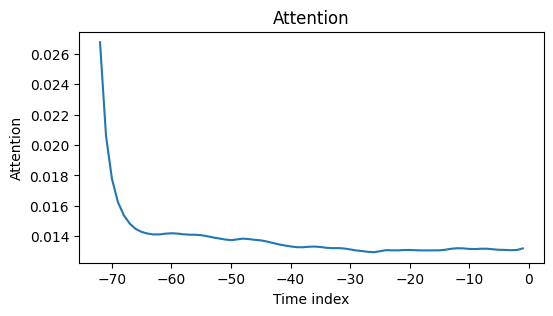

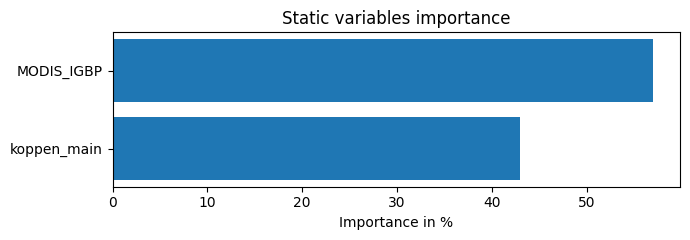

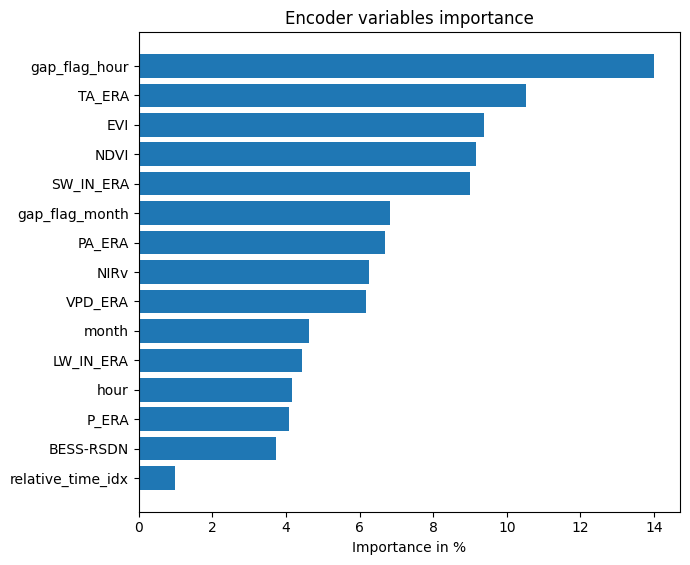

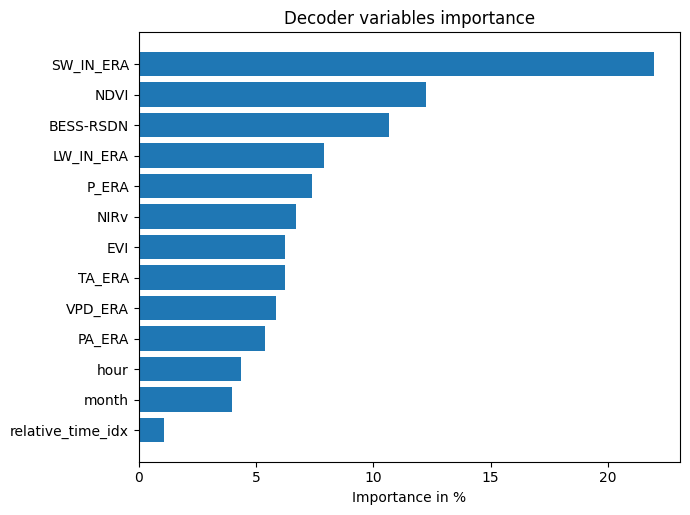

Masked Val evaluation: {'rmse': 3.6373653411865234, 'mae': 2.03023362159729, 'nse': 0.7476187944412231}
Exp 14_2, Encoder Length = 7D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


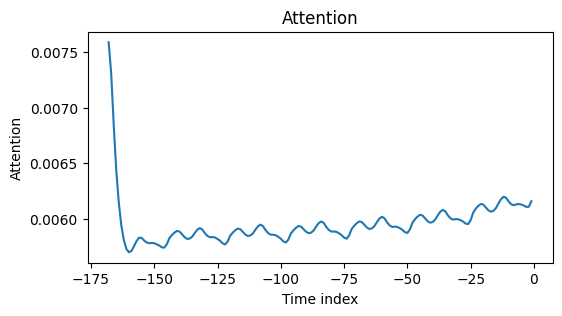

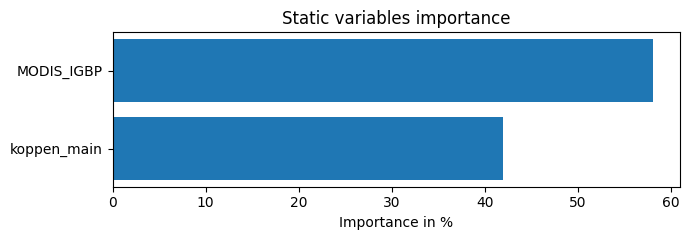

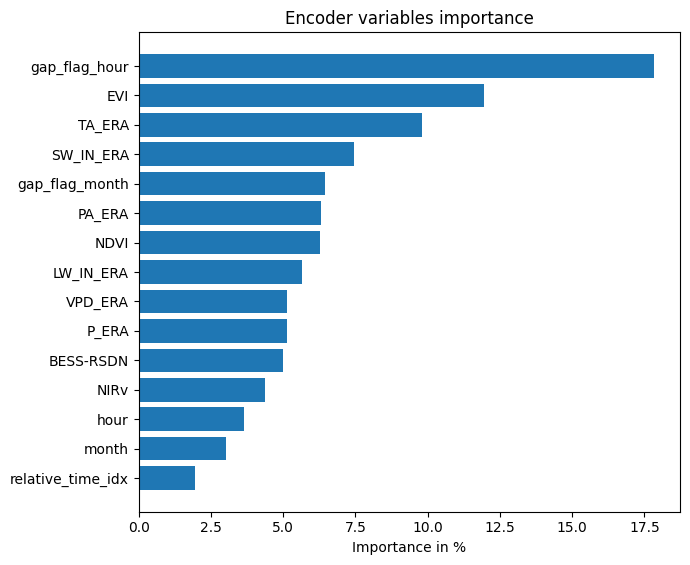

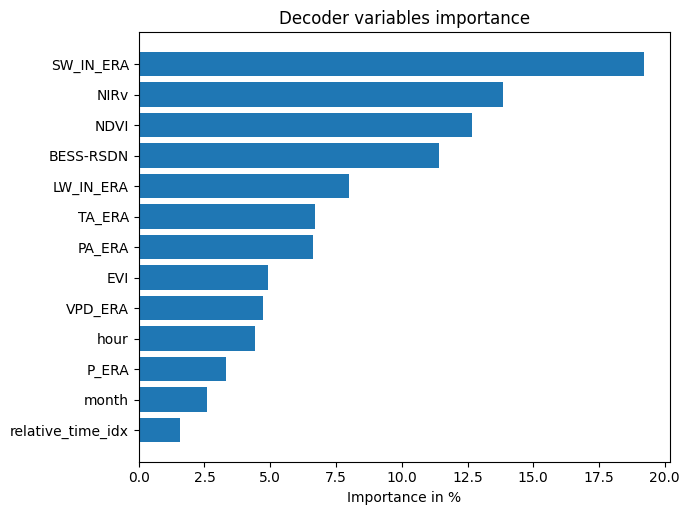

Masked Val evaluation: {'rmse': 3.586897611618042, 'mae': 1.981271505355835, 'nse': 0.7549424171447754}
Exp 14_3, Encoder Length = 14D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


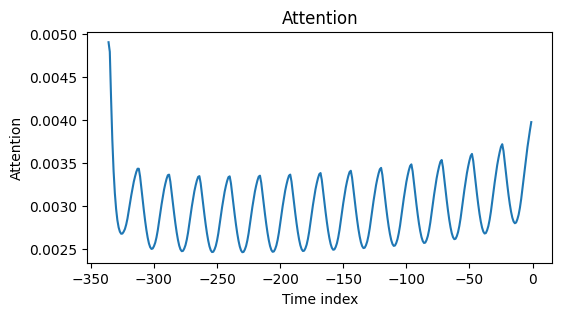

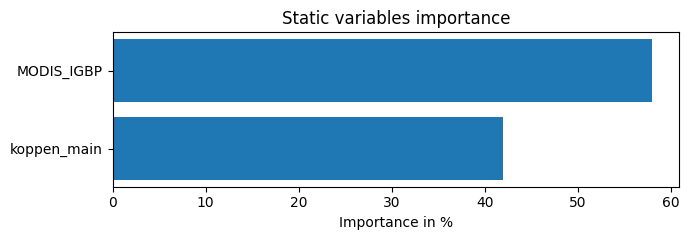

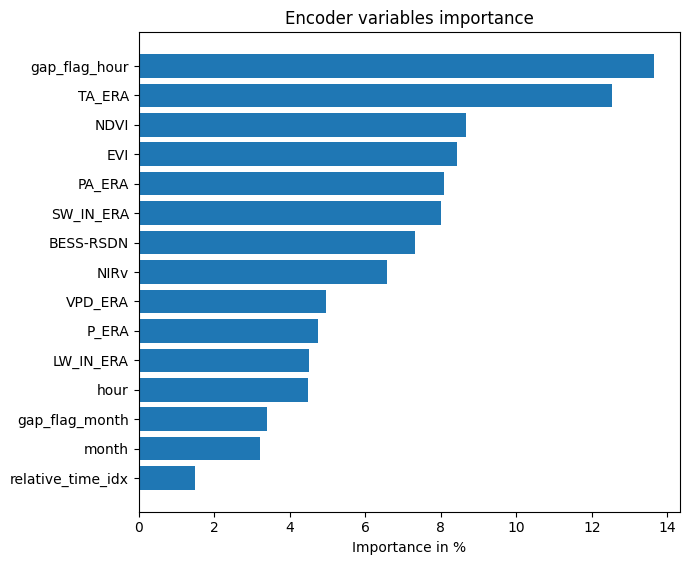

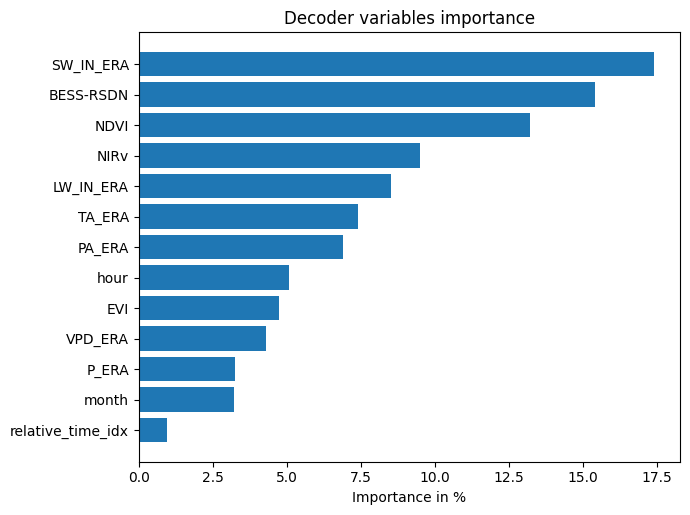

Masked Val evaluation: {'rmse': 3.62450909614563, 'mae': 2.0125973224639893, 'nse': 0.7503145933151245}
Exp 14_4, Encoder Length = 30D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


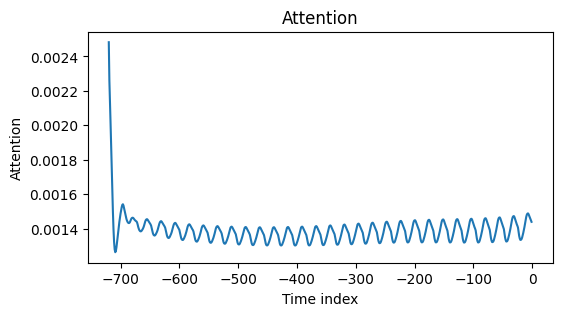

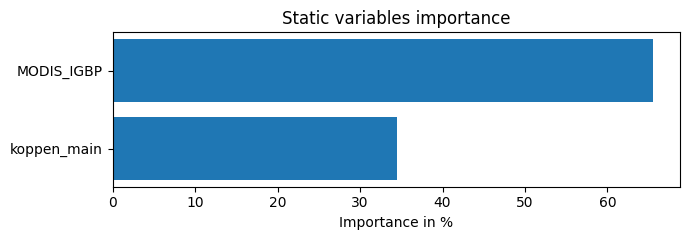

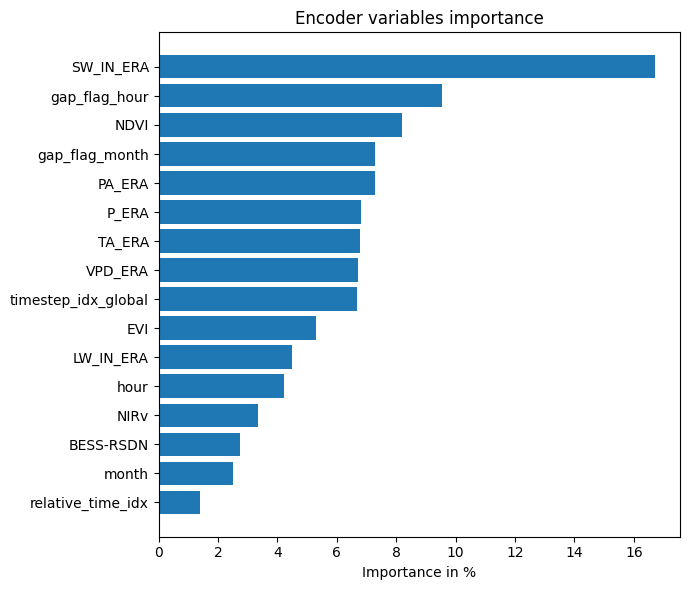

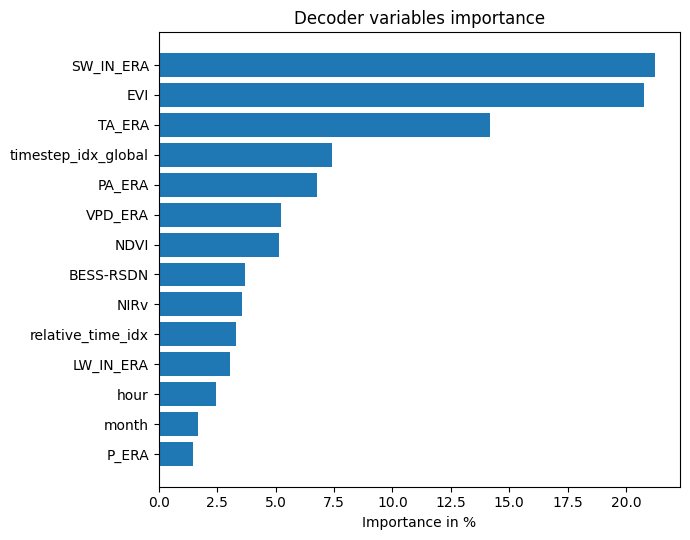

Masked Val evaluation: {'rmse': 3.977324962615967, 'mae': 2.1453874111175537, 'nse': 0.7004117965698242}


In [9]:
# Loop through experiments, get results + outputs
for i in range(len(encoder_lens)):
    print(f"\nExp 14_{i+1}, Encoder Length = {encoder_lens[i]}D")
    # Set constants
    ENCODER_LEN = 24*encoder_lens[i]
    exp_model_dir = model_dirs[i]
    best_model_path = checkpts[i]
    
    # Load best model
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    
    # Setup dataset
    train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
    train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
    if ENCODER_LEN < 24*15:
        train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)
    else:
        train, validation, _ = setup_tsdataset_nogpp_slim_w_timestep(train_df, val_df, None, ENCODER_LEN)
    
    # Get raw preds
    raw_predictions = best_tft.predict(validation, mode="raw", return_x=False, show_progress_bar=False)
    
    # Get interpretation
    interpretation_sum = best_tft.interpret_output(raw_predictions, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    plt.show(block=False)
    
    # Get preds, actuals, mask
    val_preds = raw_predictions['prediction'][:, :, 3]

    val_actuals_list = []
    mask_list = []
    for x, y in iter(validation):
        val_actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    val_actuals = torch.cat(val_actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    val_actuals = val_actuals.reshape(-1)
    val_preds = val_preds.reshape(-1)

    # Masked eval
    masked_eval_metric = get_eval_metrics_simple(val_actuals, val_preds, mask)
    print(f"Masked Val evaluation: {masked_eval_metric}")


In [ ]:
def eval_raw_preds(raw_predictions, validation):
    # Format val_preds
    val_preds = raw_predictions['prediction'][:, :, 3]
    
    # Get actuals and mask from val_dl
    val_actuals_list = []
    mask_list = []
    for x, y in iter(validation):
        val_actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    val_actuals = torch.cat(val_actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    val_actuals = val_actuals.reshape(-1)
    val_preds = val_preds.reshape(-1)

    # Masked eval
    masked_eval_metric = get_eval_metrics_simple(val_actuals, val_preds, mask)
    
    return masked_eval_metric
    